Python port of "A simple Intel RAPL reader library" by Kaz Yoshii <ky@anl.gov> from https://github.com/coolr-hpc/intercoolr

In [1]:
import os
import time
import functools

In [2]:
RAPLBASEPATH = "/sys/devices/virtual/powercap/intel-rapl/"

def read_int(fn):
    with open(fn, 'r') as fp:
        buf = fp.read()
    return int(buf.strip())


def read_str(fn):
    with open(fn, 'r') as fp:
        buf = fp.read()
    return buf


def check_readable(func):
    """Filters output path of func to be None if it's not readable"""
    @functools.wraps(func)
    def _check_readable(*args, **kwargs):
        path = func(*args, **kwargs)
        if not os.access(path, os.R_OK):
            return None
        return path
    
    return _check_readable
    

@check_readable
def getpath_sysfs_top(n, fn):
    path = os.path.join(
        RAPLBASEPATH, 
        'intel-rapl:{:d}'.format(n), 
        fn,
    )
    return path


@check_readable
def getpath_sysfs_sub(n, subn, fn):
    path = os.path.join(
        RAPLBASEPATH, 
        'intel-rapl:{:d}'.format(n), 
        'intel-rapl:{:d}:{:d}'.format(n, subn), 
        fn,
    )
    return path

In [3]:
getpath_sysfs_top(0, 'energy_uj')

'/sys/devices/virtual/powercap/intel-rapl/intel-rapl:0/energy_uj'

In [4]:
assert getpath_sysfs_top(0, 'energy_uj_asdf') is None

In [5]:
read_int(getpath_sysfs_top(0, 'energy_uj'))

84259128479

In [6]:
read_str(getpath_sysfs_sub(0, 0, 'name'))

'dram\n'

In [7]:
def unwrap(previous, current, maximum):
    """
    Correct the difference from the previous to current value 
    that wraps back to zero at maximum
    """
    if current >= previous:
        return current - previous
    
    return current + maximum - previous

assert unwrap(10, 15, 20) == 5
assert unwrap(10, 10, 20) == 0
assert unwrap(10, 5, 20) == 15

In [8]:
class RaplReader(object):
    """Interface to read RAPL values from the processor"""
    
    MAX_SOCKETS = 8

    def __init__(self):
        self.n_sockets = 0
        
        self.socket_fn = []
        # self.socket_fn_max = []
        self.socket_max = []
        self.socket_prev = []
        self.socket_hasdram = []
        
        self.dram_fn = []
        # self.dram_fn_max = []
        self.dram_max = []
        self.dram_prev = []
        
        # detect how many sockets
        self.n_sockets = self._scan_sockets()
    
        self.sample(init=True) # sample once here. then the next sample can yield correct diff
        #time.sleep(0.01)

    def _scan_sockets(self):
        for socket in range(self.MAX_SOCKETS):
            path = getpath_sysfs_top(socket, 'energy_uj')
            if path is None:
                break

            self.socket_fn.append(path)
            
            path = getpath_sysfs_top(socket, 'max_energy_range_uj')
            if path is None:
                raise RuntimeError('unknown energy max on socket {}'.format(socket))
            # self.socket_fn_max.append(path)
            self.socket_max.append(read_int(path))
            self.socket_prev.append(None)

            self.socket_hasdram.append(self._scan_socket_dram(socket))
            
        return socket
            
    def _scan_socket_dram(self, socket):
        # check if there are any dram entries
        for subn in range(4):
            path = getpath_sysfs_sub(socket, subn, 'name')
            if path is None:
                continue

            if read_str(path).strip() == 'dram':
                break
        else:
            self.dram_fn.append(None)
            self.dram_max.append(None)
            self.dram_prev.append(None)
            return False

        path = getpath_sysfs_sub(socket, subn, 'energy_uj')
        if path is None:
            raise RuntimeError()
        self.dram_fn.append(path)

        path = getpath_sysfs_sub(socket, subn, 'max_energy_range_uj')
        if path is None:
            raise RuntimeError()
        # self.dram_fn_max.append(path)
        self.dram_max.append(read_int(path))
        self.dram_prev.append(None)
        
        return True

    def sample(self, init=False):
        results = {}
        for n_socket, path in enumerate(self.socket_fn):
            rsock = results['socket{}'.format(n_socket)] = {}
            
            sample = self._sample_device(n_socket, init=init)
            if not init:
                dt, dE = sample
                rsock['cpu'] = {'s': dt, 'J': dE}
                    
            if self.socket_hasdram[n_socket]:
                sample = self._sample_device(n_socket, dram=True, init=init)
                if not init:
                    dt, dE = sample
                    rsock['dram'] = {'s': dt, 'J': dE}
        
        return results
        
    def _sample_device(self, socket, dram=False, init=False):
        path = (self.socket_fn if not dram else self.dram_fn)[socket]
        prev_l = (self.socket_prev if not dram else self.dram_prev)
        max_ = (self.socket_max if not dram else self.dram_max)[socket]
        
        t = time.monotonic()
#         E = read_uint64(path)
        with open(path, 'r') as f:
            E = int(f.read())
        
        prev = prev_l[socket]
        prev_l[socket] = t, E
        
        if not init:
            t0, E0 = prev
            dt = t - t0
            dE = unwrap(E0, E, max_)
            return dt, dE / 1e6

In [9]:
rr = RaplReader()
vars(rr)

{'dram_fn': ['/sys/devices/virtual/powercap/intel-rapl/intel-rapl:0/intel-rapl:0:0/energy_uj',
  '/sys/devices/virtual/powercap/intel-rapl/intel-rapl:1/intel-rapl:1:0/energy_uj'],
 'dram_max': [262143999938, 262143999938],
 'dram_prev': [(23661.951094754, 65641145202), (23661.951217311, 64649115478)],
 'n_sockets': 2,
 'socket_fn': ['/sys/devices/virtual/powercap/intel-rapl/intel-rapl:0/energy_uj',
  '/sys/devices/virtual/powercap/intel-rapl/intel-rapl:1/energy_uj'],
 'socket_hasdram': [True, True],
 'socket_max': [262143999938, 262143999938],
 'socket_prev': [(23661.951032049, 84345945678),
  (23661.951149979, 120625566833)]}

In [14]:
p = '/sys/devices/virtual/powercap/intel-rapl/intel-rapl:0/energy_uj'

semi_idle_uW = 40e6

bits = ''
with open(p, 'r') as f:
    for i in range(100):
        c = f.read(1)
        if not c:
            break
        if i == 2:
            with open(p, 'r') as f2:
                mid = f2.read()
        bits += c
        time.sleep(0.1)
        
uJ = int(mid) - int(bits)
print(uJ / 1e6, 'joules burnt from "first open/last read" to mid read')
print(uJ / semi_idle_uW, 'estimated seconds')

7.920349 joules burnt from "first open/last read" to mid read
0.198008725 estimated seconds


It looks like when the file is opened it is immediately 'filled' by the driver with the number. The bytes wouldn't seem to change in an open handle.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [45]:
samples = []
time.sleep(0.1 - time.monotonic() % 0.1)
rr.sample()
for x in range(10):
    time.sleep(0.1 - time.monotonic() % 0.1)
    samples.append(rr.sample())

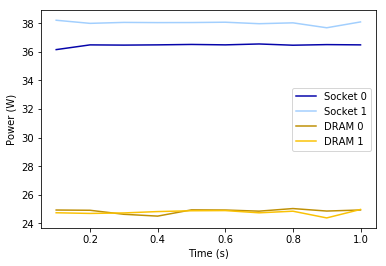

In [47]:
f, ax = plt.subplots()
for socket, color in zip(samples[0], ['xkcd:royal blue', 'xkcd:baby blue']):
    cpu_samples = [s[socket]['cpu'] for s in samples]
    times = np.cumsum([cs['s'] for cs in cpu_samples])
    cpu_power = [cs['J'] / cs['s'] for cs in cpu_samples]
    plt.plot(times, cpu_power, label='Socket {}'.format(socket[-1]), color=color)
    
for socket, color in zip(samples[0], ['xkcd:ochre', 'xkcd:goldenrod']):
    cpu_samples = [s[socket]['dram'] for s in samples]
    times = np.cumsum([cs['s'] for cs in cpu_samples])
    cpu_power = [cs['J'] / cs['s'] for cs in cpu_samples]
    plt.plot(times, cpu_power, label='DRAM {}'.format(socket[-1]), color=color)
    
ax.set_ylabel('Power (W)')
ax.set_xlabel('Time (s)')
ax.legend()